In [250]:
import pandas as pd
import plotly.express as px
import numpy as np
import os
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:.2f}'.format

warnings.filterwarnings("ignore")

# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd
from astral.sun import sun
from astral import LocationInfo
from skforecast.datasets import fetch_dataset
from feature_engine.datetime import DatetimeFeatures
from feature_engine.creation import CyclicalFeatures
from feature_engine.timeseries.forecasting import WindowFeatures

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from skforecast.plot import plot_residuals
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({'font.size': 8})

# Modelling and Forecasting
# ==============================================================================
import skforecast
import lightgbm
import sklearn
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
from skforecast.recursive import ForecasterEquivalentDate, ForecasterRecursive
from skforecast.direct import ForecasterDirect
from skforecast.model_selection import TimeSeriesFold, bayesian_search_forecaster, backtesting_forecaster
from skforecast.feature_selection import select_features
from skforecast.preprocessing import RollingFeatures
from skforecast.plot import calculate_lag_autocorrelation, plot_residuals
from skforecast.metrics import calculate_coverage
import shap

url_daily = "https://media.githubusercontent.com/media/ruanvirginio/masters/refs/heads/main/bases_tratadas/daily_peak_transformers_dataset.csv"
df_daily = pd.read_csv(url_daily,  sep=';', encoding='latin-1')

df = df_daily

data = df.copy()
data = data.loc[data.id == 'T21a']
data['Time'] = pd.to_datetime(data['datahora'], format='%Y-%m-%d')
data = data.set_index('Time')
data = data.sort_index()
data#.head(2)

,id,datahora,Smax,Smin,Smed
Time,,,,,
2018-01-01,T21a,2018-01-01,0.27,0.21,0.24
2018-01-02,T21a,2018-01-02,0.74,0.22,0.46
2018-01-03,T21a,2018-01-03,0.79,0.24,0.60
2018-01-04,T21a,2018-01-04,0.78,0.75,0.76
2018-01-05,T21a,2018-01-05,0.75,0.29,0.64
...,...,...,...,...,...
2024-12-27,T21a,2024-12-27,0.63,0.23,0.42
2024-12-28,T21a,2024-12-28,0.49,0.24,0.35
2024-12-29,T21a,2024-12-29,0.34,0.23,0.28


In [251]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2557 entries, 2018-01-01 to 2024-12-31
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        2557 non-null   object 
 1   datahora  2557 non-null   object 
 2   Smax      2513 non-null   float64
 3   Smin      2513 non-null   float64
 4   Smed      2513 non-null   float64
dtypes: float64(3), object(2)
memory usage: 119.9+ KB


In [252]:
# Define expected frequency (daily, based on your dates)
freq = "D"

full_index = pd.date_range(
    start=data.index.min(),
    end=data.index.max(),
    freq=freq
)

data_full = data.reindex(full_index)

data_interpolated = data_full.interpolate(method="time")

data_interpolated = (
    data_interpolated
    .interpolate(method="time")
    .ffill()
    .bfill()
)

data = data_interpolated

data['datahora'] = pd.to_datetime(data['datahora'])

In [253]:
data = data.loc[data['datahora'].dt.date > pd.to_datetime('2021-12-31').date()]


In [254]:
# Verificação se possui os 2557 rows ou tem index faltando

start_date = data.index.min()
end_date = data.index.max()
complete_date_range = pd.date_range(start=start_date, end=end_date, freq=data.index.freq)
is_index_complete = (data.index == complete_date_range).all()
print(f"Index complete: {is_index_complete}")
print(f"Number of rows with missing values: {data.isnull().any(axis=1).mean()}")


missing = complete_date_range.difference(data.index)
print(f"Missing timestamps: {(missing)}")


Index complete: True
Number of rows with missing values: 0.0
Missing timestamps: DatetimeIndex([], dtype='datetime64[ns]', freq='D')


In [255]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2022-01-01 to 2024-12-31
Freq: D
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        1096 non-null   object        
 1   datahora  1096 non-null   datetime64[ns]
 2   Smax      1096 non-null   float64       
 3   Smin      1096 non-null   float64       
 4   Smed      1096 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(1)
memory usage: 51.4+ KB


In [256]:
data

,id,datahora,Smax,Smin,Smed
2022-01-01,T21a,2022-01-01,0.26,0.21,0.23
2022-01-02,T21a,2022-01-02,0.32,0.21,0.25
2022-01-03,T21a,2022-01-03,0.63,0.22,0.40
2022-01-04,T21a,2022-01-04,0.65,0.23,0.42
2022-01-05,T21a,2022-01-05,0.64,0.23,0.41
...,...,...,...,...,...
2024-12-27,T21a,2024-12-27,0.63,0.23,0.42
2024-12-28,T21a,2024-12-28,0.49,0.24,0.35
2024-12-29,T21a,2024-12-29,0.34,0.23,0.28
2024-12-30,T21a,2024-12-30,0.61,0.24,0.40


In [257]:
# Split data into train-val-test
end_train = '2022-12-31 23:59:00'
end_validation = '2023-12-31 23:59:00'
data_train = data.loc[: end_train, :].copy()
data_val   = data.loc[end_train:end_validation, :].copy()
data_test  = data.loc[end_validation:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

Train dates      : 2022-01-01 00:00:00 --- 2022-12-31 00:00:00  (n=365)
Validation dates : 2023-01-01 00:00:00 --- 2023-12-31 00:00:00  (n=365)
Test dates       : 2024-01-01 00:00:00 --- 2024-12-31 00:00:00  (n=366)


In [258]:
# Interactive plot of time series
# ==============================================================================
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_train.index, y=data_train['Smax'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=data_val.index, y=data_val['Smax'], mode='lines', name='Validation'))
fig.add_trace(go.Scatter(x=data_test.index, y=data_test['Smax'], mode='lines', name='Test'))
fig.update_layout(
    title='Daily energy demand',
    xaxis_title="Time",
    yaxis_title="Smax",
    legend_title="Partition:",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(orientation="h", yanchor="top", y=1, xanchor="left", x=0.001)
)
#fig.update_xaxes(rangeslider_visible=True)
fig.show()


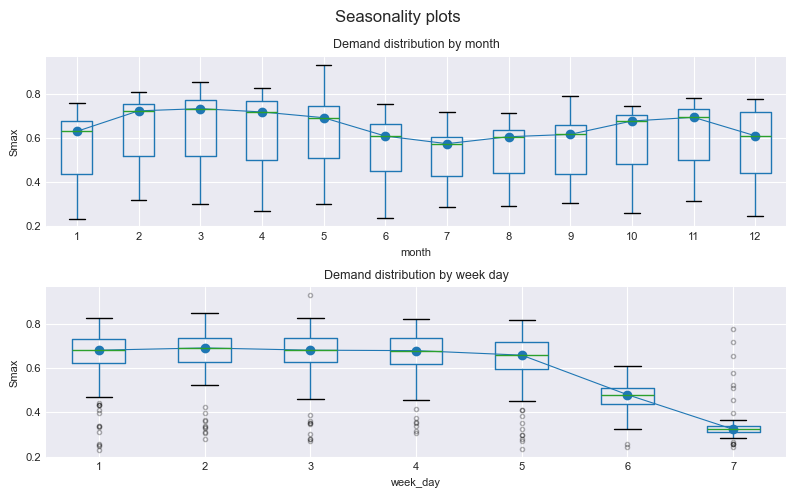

In [259]:
# Annual, weekly and daily seasonality
# ==============================================================================
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(8, 5), sharex=False, sharey=True)
axs = axs.ravel()

# Demand distribution by month
data['month'] = data.index.month
data.boxplot(column='Smax', by='month', ax=axs[0], flierprops={'markersize': 3, 'alpha': 0.3})
data.groupby('month')['Smax'].median().plot(style='o-', linewidth=0.8, ax=axs[0])
axs[0].set_ylabel('Smax')
axs[0].set_title('Demand distribution by month', fontsize=9)

# Demand distribution by week day
data['week_day'] = data.index.day_of_week + 1
data.boxplot(column='Smax', by='week_day', ax=axs[1], flierprops={'markersize': 3, 'alpha': 0.3})
data.groupby('week_day')['Smax'].median().plot(style='o-', linewidth=0.8, ax=axs[1])
axs[1].set_ylabel('Smax')
axs[1].set_title('Demand distribution by week day', fontsize=9)

fig.suptitle("Seasonality plots", fontsize=12)
fig.tight_layout()


##### Baseline model

In [260]:
# Create baseline: value of the same hour of the previous day
# ==============================================================================
forecaster = ForecasterEquivalentDate(
                 offset    = pd.DateOffset(days=365),
                 n_offsets = 1
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=data.loc[:end_validation, 'Smax'])
forecaster


======================== 
ForecasterEquivalentDate 
======================== 
Offset: <DateOffset: days=365> 
Number of offsets: 1 
Aggregation function: mean 
Window size: 365 
Series name: Smax 
Training range: [Timestamp('2022-01-01 00:00:00'), Timestamp('2023-12-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: <Day> 
Creation date: 2026-01-26 13:35:40 
Last fit date: 2026-01-26 13:35:40 
Skforecast version: 0.19.1 
Python version: 3.11.0 
Forecaster id: None

In [261]:
# Backtesting
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 365,
        initial_train_size = len(data.loc[:end_validation]),
        refit              = False
)
metric, predictions = backtesting_forecaster(
                          forecaster = forecaster,
                          y          = data['Smax'],
                          cv         = cv,
                          metric     = 'mean_absolute_error'
                       )
metric


100%|██████████| 2/2 [00:00<00:00, 104.28it/s]


,mean_absolute_error
0,0.15


#### Recursive multi-step forecasting


In [262]:
# Create forecaster using LGBM
# ==============================================================================
window_features = RollingFeatures(stats=["mean"], window_sizes=365 * 1) # predict proximos 365 dias, movbing average dos últimos 1 anos
forecaster = ForecasterRecursive(
                 estimator       = LGBMRegressor(random_state=100, verbose=-1),
                 lags            = 365,
                 window_features = window_features
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=data.loc[:end_validation, 'Smax'])
forecaster


=================== 
ForecasterRecursive 
=================== 
Estimator: LGBMRegressor 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252
 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270
 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288
 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306
 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324
 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342
 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360
 361 362 363 364 365] 
Window features: ['roll_mean_365'] 
Window size: 365 
Series name: Smax 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2022-01-01 00:00:00'), Timestamp('2023-12-31 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: <Day> 
Estimator parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 100, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2026-01-26 13:35:40 
Last fit date: 2026-01-26 13:35:40 
Skforecast version: 0.19.1 
Python version: 3.11.0 
Forecaster id: None

In [263]:
# from xgboost import XGBRegressor
# from skforecast.preprocessing import RollingFeatures
# from skforecast.recursive import ForecasterRecursive

# window_features = RollingFeatures(
#     stats=["mean"],
#     window_sizes=365
# )

# forecaster = ForecasterRecursive(
#     estimator=XGBRegressor(
#         random_state=100,
#         verbosity=0,          # <- correto
#         n_estimators=300,
#         max_depth=6,
#         learning_rate=0.05
#     ),
#     lags=365,
#     window_features=window_features
# )

# forecaster.fit(y=data.loc[:end_validation, 'Smax'])


In [264]:
# Backtesting
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster    = forecaster,
                          y             = data['Smax'],
                          cv            = cv,
                          metric        = 'mean_absolute_error',
                          verbose       = True, # Set to False to avoid printing
                      )




Information of folds
--------------------
Number of observations used for initial training: 730
Number of observations used for backtesting: 366
    Number of folds: 2
    Number skipped folds: 0 
    Number of steps per fold: 365
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0
    Last fold only includes 1 observations.

Fold: 0
    Training:   2022-01-01 00:00:00 -- 2023-12-31 00:00:00  (n=730)
    Validation: 2024-01-01 00:00:00 -- 2024-12-30 00:00:00  (n=365)
Fold: 1
    Training:   No training in this fold
    Validation: 2024-12-31 00:00:00 -- 2024-12-31 00:00:00  (n=1)



100%|██████████| 2/2 [00:00<00:00,  5.30it/s]


In [265]:
# Plot predictions vs real value (LGBM REGRESSOR)
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=data_test.index, y=data_test['Smax'], name="test", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Real value vs predicted in test data",
    xaxis_title="Date time",
    yaxis_title="Demand",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(orientation="h", yanchor="top", y=1.01, xanchor="left", x=0)
)
fig.show()

metric


,mean_absolute_error
0,0.07


The autoregressive model achieves a lower MAE than the baseline model. This means that the autoregressive model is able to predict the next day's electricity demand more accurately than the baseline model.


In [266]:
data

,id,datahora,Smax,Smin,Smed,month,week_day
2022-01-01,T21a,2022-01-01,0.26,0.21,0.23,1,6
2022-01-02,T21a,2022-01-02,0.32,0.21,0.25,1,7
2022-01-03,T21a,2022-01-03,0.63,0.22,0.40,1,1
2022-01-04,T21a,2022-01-04,0.65,0.23,0.42,1,2
2022-01-05,T21a,2022-01-05,0.64,0.23,0.41,1,3
...,...,...,...,...,...,...,...
2024-12-27,T21a,2024-12-27,0.63,0.23,0.42,12,5
2024-12-28,T21a,2024-12-28,0.49,0.24,0.35,12,6
2024-12-29,T21a,2024-12-29,0.34,0.23,0.28,12,7
2024-12-30,T21a,2024-12-30,0.61,0.24,0.40,12,1


## Multivariate

In [267]:
url_GD = "https://media.githubusercontent.com/media/ruanvirginio/masters/refs/heads/main/bases_tratadas/dg_dataset.csv"
gd = pd.read_csv(url_GD,  sep=';', encoding='latin-1')

gd['datahora'] = pd.to_datetime(gd['datahora'])


# url_clientes = "https://media.githubusercontent.com/media/ruanvirginio/masters/refs/heads/main/bases_tratadas/customers_dataset.csv"
# clientes = pd.read_csv(url_clientes, sep=';', encoding='latin-1')

In [268]:
# ONE HOT ENCODING DE CLIENTES

# clientes['datahora'] = pd.to_datetime(clientes['datahora'])

# # One-hot encoding
# dummies = pd.get_dummies(clientes[['CLASSE', 'DSC_GRUPO_FORNECIMENTO']].astype(str),
#                          prefix=['classe', 'fornec'])

# # Multiplicando as colunas pelo valor de QTD_CLIENTES, pra ser um "peso"
# dummies_mult = dummies.multiply(clientes['QTD_CLIENTES'], axis=0)

# clientes_concat = pd.concat([clientes[['id', 'datahora']], dummies_mult], axis=1)
# clientes2 = clientes_concat.groupby(['id', 'datahora']).sum().reset_index()
# clientes2.drop('classe_0', axis=1) # drop classe que n existe

# clientes2

In [269]:
# clientes = clientes[['id', 'datahora', 'QTD_CLIENTES']]

In [270]:
# clientes2 = clientes.groupby(['id', 'datahora']).sum().reset_index()


In [271]:
# clientes2.loc[clientes2.id == 'T21a']

In [272]:
# gd_clientes = pd.merge(
#     clientes2,
#     gd,
#     on=['datahora', 'id'],
#     how='left'
# )
# gd_clientes

In [273]:
df_multivariate = pd.merge(
    data,
    gd,
    on=['datahora', 'id'],
    how='left'
)
df_multivariate

,id,datahora,Smax,Smin,Smed,month,week_day,S_GD
0,T21a,2022-01-01,0.26,0.21,0.23,1,6,0.48
1,T21a,2022-01-02,0.32,0.21,0.25,1,7,0.48
2,T21a,2022-01-03,0.63,0.22,0.40,1,1,0.48
3,T21a,2022-01-04,0.65,0.23,0.42,1,2,0.48
4,T21a,2022-01-05,0.64,0.23,0.41,1,3,0.48
...,...,...,...,...,...,...,...,...
1091,T21a,2024-12-27,0.63,0.23,0.42,12,5,2.02
1092,T21a,2024-12-28,0.49,0.24,0.35,12,6,2.02
1093,T21a,2024-12-29,0.34,0.23,0.28,12,7,2.02
1094,T21a,2024-12-30,0.61,0.24,0.40,12,1,2.02


In [274]:
df_multivariate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        1096 non-null   object        
 1   datahora  1096 non-null   datetime64[ns]
 2   Smax      1096 non-null   float64       
 3   Smin      1096 non-null   float64       
 4   Smed      1096 non-null   float64       
 5   month     1096 non-null   int32         
 6   week_day  1096 non-null   int32         
 7   S_GD      1096 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int32(2), object(1)
memory usage: 60.1+ KB


In [275]:
df_multivariate.columns

Index(['id', 'datahora', 'Smax', 'Smin', 'Smed', 'month', 'week_day', 'S_GD'], dtype='object')

In [276]:
# SENO E COSSENO DE MES E DIA DA SEMANA

df_multivariate['week_day_sin'] = np.sin(2 * np.pi * df_multivariate['week_day'] / 7)
df_multivariate['week_day_cos'] = np.cos(2 * np.pi * df_multivariate['week_day'] / 7)

df_multivariate['month_sin'] = np.sin(2 * np.pi * df_multivariate['month'] / 12)
df_multivariate['month_cos'] = np.cos(2 * np.pi * df_multivariate['month'] / 12)

df_multivariate

,id,datahora,Smax,Smin,Smed,month,week_day,S_GD,week_day_sin,week_day_cos,month_sin,month_cos
0,T21a,2022-01-01,0.26,0.21,0.23,1,6,0.48,-0.78,0.62,0.50,0.87
1,T21a,2022-01-02,0.32,0.21,0.25,1,7,0.48,-0.00,1.00,0.50,0.87
2,T21a,2022-01-03,0.63,0.22,0.40,1,1,0.48,0.78,0.62,0.50,0.87
3,T21a,2022-01-04,0.65,0.23,0.42,1,2,0.48,0.97,-0.22,0.50,0.87
4,T21a,2022-01-05,0.64,0.23,0.41,1,3,0.48,0.43,-0.90,0.50,0.87
...,...,...,...,...,...,...,...,...,...,...,...,...
1091,T21a,2024-12-27,0.63,0.23,0.42,12,5,2.02,-0.97,-0.22,-0.00,1.00
1092,T21a,2024-12-28,0.49,0.24,0.35,12,6,2.02,-0.78,0.62,-0.00,1.00
1093,T21a,2024-12-29,0.34,0.23,0.28,12,7,2.02,-0.00,1.00,-0.00,1.00
1094,T21a,2024-12-30,0.61,0.24,0.40,12,1,2.02,0.78,0.62,-0.00,1.00


In [277]:
df_multivariate.drop(columns=['month', 'week_day'], inplace=True)


In [278]:
data = df_multivariate

In [279]:
# exog_features = ['Smin', 'Smed', 'classe_0', 'classe_1',
#        'classe_2', 'classe_3', 'classe_4', 'classe_5', 'classe_6', 'classe_7',
#        'classe_8', 'fornec_ALTA', 'fornec_BAIXA', 'S_GD', 'week_day_sin',
#        'week_day_cos', 'month_sin', 'month_cos']



In [280]:
data['Time'] = pd.to_datetime(data['datahora'], format='%Y-%m-%d')
data = data.set_index('Time')
data = data.sort_index()

# Define expected frequency (daily, based on your dates)
freq = "D"

full_index = pd.date_range(
    start=data.index.min(),
    end=data.index.max(),
    freq=freq
)

data_full = data.reindex(full_index)

data = data_full

data['datahora'] = pd.to_datetime(data['datahora'])

In [281]:
import holidays
from datetime import timedelta
from dateutil.easter import easter

# feriados oficiais
br_pb_jp_holidays = holidays.Brazil(subdiv='PB')

def carnaval_dates(year):
    easter_day = easter(year)
    carnaval_tuesday = easter_day - timedelta(days=47)
    carnaval_monday  = easter_day - timedelta(days=48)
    return [carnaval_monday, carnaval_tuesday]

# Adicionar carnaval para todos os anos do dataset
years = data.index.year.unique()

for year in years:
    for day in carnaval_dates(year):
        br_pb_jp_holidays[day] = "Carnaval"

data['is_holiday'] = data.index.map(
    lambda x: x in br_pb_jp_holidays
).astype(int)

In [282]:
exog_features = ['week_day_sin', 'week_day_cos', 'month_sin', 'month_cos', 'is_holiday']

In [283]:
# Backtesting model
# ==============================================================================
metric, predictions = backtesting_forecaster(
                          forecaster = forecaster,
                          y          = data['Smax'],
                          exog       = data[exog_features],
                          cv         = cv,
                          metric     = 'mean_absolute_error'
                      )
display(metric)
predictions.head()

100%|██████████| 2/2 [00:00<00:00,  4.86it/s]


,mean_absolute_error
0,0.07


,fold,pred
2024-01-01,0,0.68
2024-01-02,0,0.66
2024-01-03,0,0.57
2024-01-04,0,0.58
2024-01-05,0,0.52


In [284]:
# Plot prediction intervals vs real value
# ==============================================================================
fig = go.Figure([
    go.Scatter(
        name='Prediction', x=predictions.index, y=predictions['pred'], mode='lines',
    ),
    go.Scatter(
        name='Real value', x=data_test.index, y=data_test['Smax'], mode='lines',
    # ),
    # go.Scatter(
    #     name='Upper Bound', x=predictions.index, y=predictions['upper_bound'],
    #     mode='lines', marker=dict(color="#444"), line=dict(width=0), showlegend=False
    # ),
    # go.Scatter(
    #     name='Lower Bound', x=predictions.index, y=predictions['lower_bound'],
    #     marker=dict(color="#444"), line=dict(width=0), mode='lines',
    #     fillcolor='rgba(68, 68, 68, 0.3)', fill='tonexty', showlegend=False
    )
])
fig.update_layout(
    title="Real value vs predicted in test data",
    xaxis_title="Date time",
    yaxis_title="Smax",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    hovermode="x",
    legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="left", x=0.001)
)
fig.show()
